In [7]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages
import math
import scienceplots

import pandas as pd

In [8]:
plt.style.use(['science', 'no-latex'])

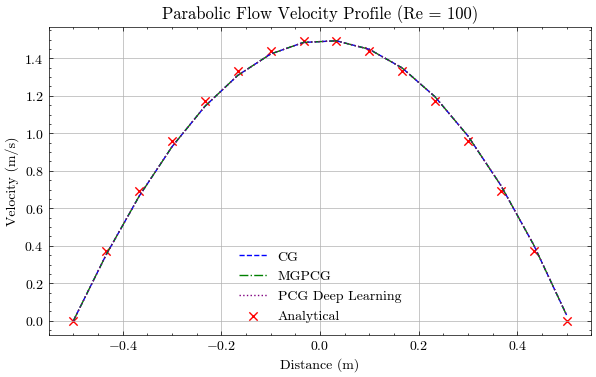

In [9]:
def parabola_profile_frisch(y, Q, ly):
    """
    Calculates the velocity parabola profile defined by the formula from Jêrome Frisch.

    Arguments:
    y : numpy array
        Distance from the centerline of the domain.
    Q : float
        Flow rate.
    ly : float
        Height of the domain.

    Returns:
    numpy array : Velocity at distance y from the centerline of the domain.
    """
    return (6 * Q / ly**3) * (ly**2 / 4 - y**2)

# Parameters
ly = 1.0  # Height of the domain (units: m)
Ny = 16  # Number of points in the y direction
Q = 1 * 1 # ly * ux_in

# Create grid
y_values = np.linspace(-ly/2, ly/2, Ny)

# Calculate velocity profiles along y-axis analytically
u_analytical = parabola_profile_frisch(y_values, Q, ly)

# CG
u = np.loadtxt("experiments_2d/shear_flow/128/cg/u.dat").T
u = u[1:-1, 1:-1]
u_numerical = u[:, -1]
# shift the x-values of the numerical solution, so that the first x is as zero
u_numerical = u_numerical - u_numerical[0]
# Scale the numerical solution to match the analytical solution
u_numerical *= u_analytical.max() / u_numerical.max()
u_cg = u_numerical

# MGPCG
u = np.loadtxt("experiments_2d/shear_flow/128/mgpcg/u.dat").T
u = u[1:-1, 1:-1]
u_numerical = u[:, -1]
# shift the x-values of the numerical solution, so that the first x is as zero
u_numerical = u_numerical - u_numerical[0]
# Scale the numerical solution to match the analytical solution
u_numerical *= u_analytical.max() / u_numerical.max()
u_mgpcg = u_numerical

# DCDM
u = np.loadtxt("experiments_2d/shear_flow/128/dcdm/u.dat").T
u = u[1:-1, 1:-1]
u_numerical = u[:, -1]
# shift the x-values of the numerical solution, so that the first x is as zero
u_numerical = u_numerical - u_numerical[0]
# Scale the numerical solution to match the analytical solution
u_numerical *= u_analytical.max() / u_numerical.max()
u_dcdm = u_numerical

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(y_values, u_cg, label='CG', color='blue', linestyle='--')
plt.plot(y_values, u_mgpcg, label='MGPCG', color='green', linestyle='-.')
plt.plot(y_values, u_dcdm, label='PCG Deep Learning', color='purple', linestyle=':')
# scatter plot the analytical solution
plt.scatter(y_values, u_analytical, label='Analytical', color='red', marker='x')
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.title('Parabolic Flow Velocity Profile (Re = 100)')
plt.legend()
plt.grid(True)
plt.savefig("shear_flow_velocity_profile.pdf", format='pdf')
plt.show()

In [10]:
pivot_data_u = {
    'Analytical_u': u_analytical,
    'MGPCG_u': u_mgpcg,
    'CG_u': u_cg,
    'DCDM_u': u_dcdm
}

In [11]:
# Create DataFrame for RMSE calculation
def calculate_rmse(reference, values):
    mask = ~np.isnan(reference) & ~np.isnan(values)
    ref_values = reference[mask]
    val_values = values[mask]
    rmse = np.sqrt(np.mean((ref_values - val_values) ** 2))
    return rmse

In [12]:
df_u = pd.DataFrame(pivot_data_u)

# Calculate RMSE
rmse_values_u = {
    'Analytical_Analytical_u': 0,  # This is always 0, since we are comparing the same data
    'Analytical_MGPCG_u': calculate_rmse(df_u['Analytical_u'].values, df_u['MGPCG_u'].values),
    'Analytical_CG_u': calculate_rmse(df_u['Analytical_u'].values, df_u['CG_u'].values),
    'Analytical_DCDM_u': calculate_rmse(df_u['Analytical_u'].values, df_u['DCDM_u'].values),
    'MGPCG_Analytical_u': calculate_rmse(df_u['MGPCG_u'].values, df_u['Analytical_u'].values),
    'MGPCG_MGPCG_u': 0,  # This is always 0, since we are comparing the same data
    'MGPCG_CG_u': calculate_rmse(df_u['MGPCG_u'].values, df_u['CG_u'].values),
    'MGPCG_DCDM_u': calculate_rmse(df_u['MGPCG_u'].values, df_u['DCDM_u'].values),
    'CG_Analytical_u': calculate_rmse(df_u['CG_u'].values, df_u['Analytical_u'].values),
    'CG_MGPCG_u': calculate_rmse(df_u['CG_u'].values, df_u['MGPCG_u'].values),
    'CG_CG_u': 0,  # This is always 0, since we are comparing the same data
    'CG_DCDM_u': calculate_rmse(df_u['CG_u'].values, df_u['DCDM_u'].values),
    'DCDM_Analytical_u': calculate_rmse(df_u['DCDM_u'].values, df_u['Analytical_u'].values),
    'DCDM_MGPCG_u': calculate_rmse(df_u['DCDM_u'].values, df_u['MGPCG_u'].values),
    'DCDM_CG_u': calculate_rmse(df_u['DCDM_u'].values, df_u['CG_u'].values),
    'DCDM_DCDM_u': 0  # This is always 0, since we are comparing the same data
}

In [13]:
def extract_names(key):
    parts = key.split('_')
    return parts[0], parts[1]

In [14]:
# Initialize dictionaries to hold the DataFrames' data
data_u = {}

# Populate the data for 'u'
for key, value in rmse_values_u.items():
    col, row = extract_names(key)
    if col not in data_u:
        data_u[col] = {}
    data_u[col][row] = value

# Create DataFrames
df_rmse_u = pd.DataFrame(data_u)

pd.set_option('display.precision', 8)

# Display the DataFrames
print("RMSE DataFrame for 'u':")
print(df_rmse_u.to_latex(float_format="%.8f"))

RMSE DataFrame for 'u':
\begin{tabular}{lrrrr}
\toprule
 & Analytical & MGPCG & CG & DCDM \\
\midrule
Analytical & 0.00000000 & 0.02286525 & 0.02286534 & 0.02286514 \\
MGPCG & 0.02286525 & 0.00000000 & 0.00000070 & 0.00000038 \\
CG & 0.02286534 & 0.00000070 & 0.00000000 & 0.00000089 \\
DCDM & 0.02286514 & 0.00000038 & 0.00000089 & 0.00000000 \\
\bottomrule
\end{tabular}

